<a href="https://colab.research.google.com/github/worldofaryavart/colab_notebooks/blob/colabnotebook/FraudTransactionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries

Here we will import all required libraries that we'll use in this notebook for training the model, visualizing the dataset and making prediction from the trained model.


In [124]:
import pandas as pd
import numpy as numpy
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

Let's check if we have a GPU available.

In [125]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


we have gpu avaiable as i am using google colab now i will check gpu's specifications' using '!nvidia-smi'

In [126]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Loading the data

I have my dataset available on my google drive so i mounted it with colab now i can use it without having any problem

let's check if dataset is loading correctly, checking its shape, first 10 rows using 'df.head()' and it's info to get more insights about features datatypes etc

In [127]:
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Fraud.csv'
df = pd.read_csv(file_path)

print(f"Number of rows: {len(df)}")
print(f"Number of columns: {df.shape[1]}")
print("/nFirst few rows")
print(df.head())
print("/nDataset info")
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of rows: 6362620
Number of columns: 11
/nFirst few rows
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1      

now we have checked dataset info let's do df.describe() to get more insights about dataset

In [128]:
print(df.describe())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

## Visualize the data to get more insights

visualizing data to get the features that's important for us to use and dropping the features that are not so important.

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

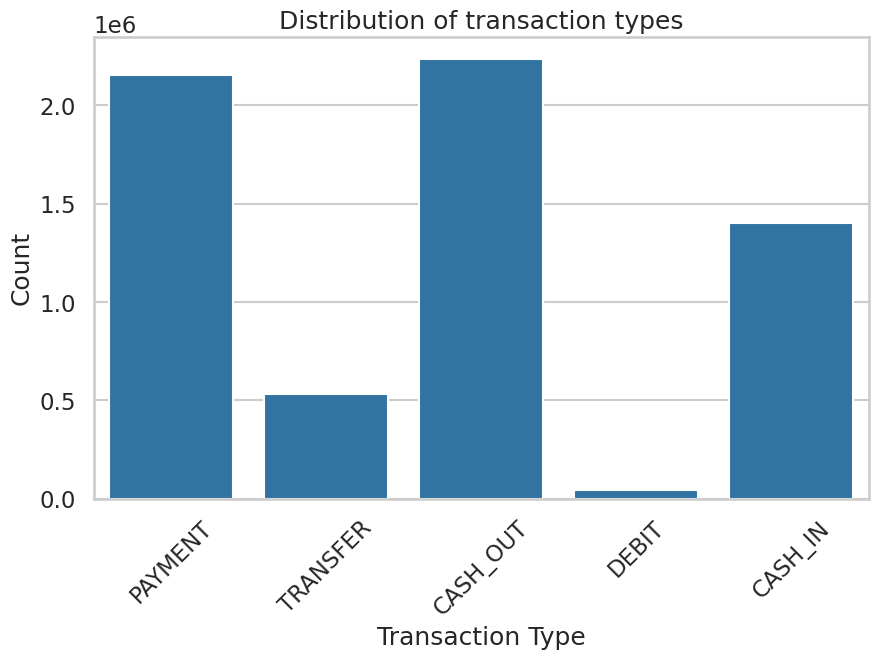

In [130]:
plt.figure(figsize = (10, 6))
sns.countplot(x = 'type', data = df)
plt.title('Distribution of transaction types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


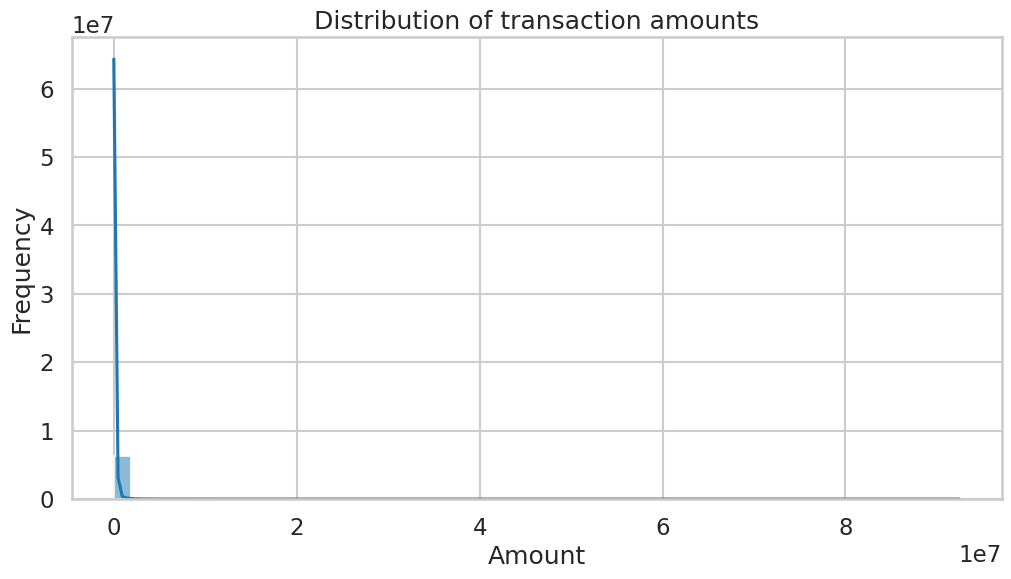

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64


In [131]:
plt.figure(figsize = (12, 6))
sns.histplot(df['amount'], bins = 50, kde = True)
plt.title('Distribution of transaction amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

print(df['amount'].describe())

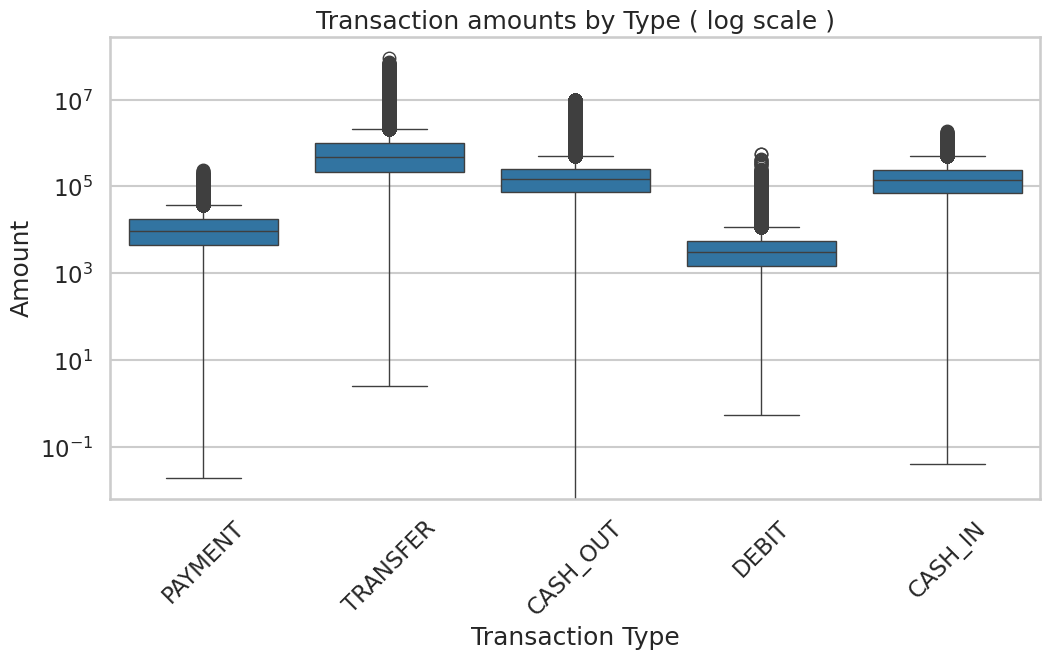

In [132]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'type', y = 'amount', data = df)
plt.yscale('log')
plt.title('Transaction amounts by Type ( log scale )')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

heatmap i think will be useful, let's check correlation between features using heatmap

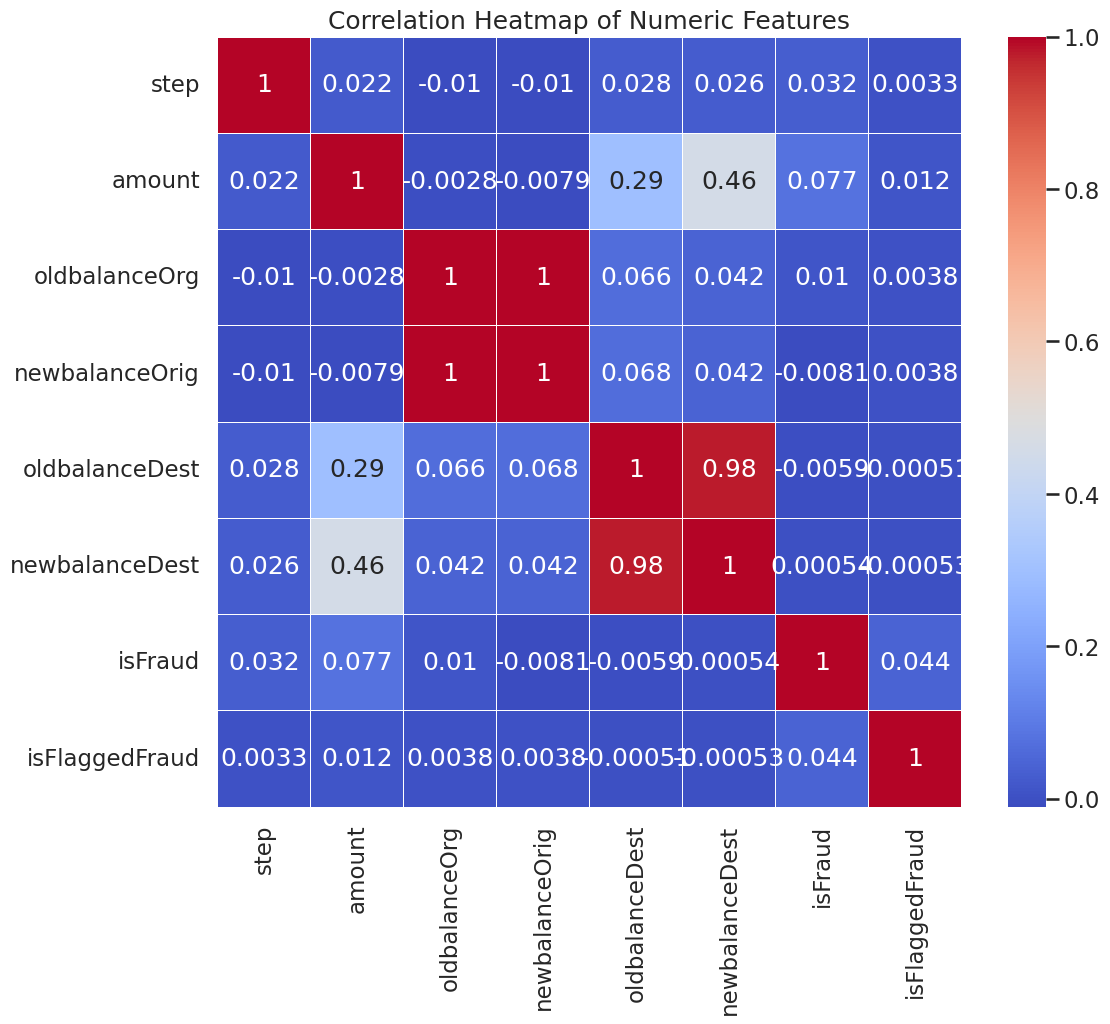

In [133]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


as we can see there is keytakeways we can see in the heatmap
1. 'oldbalanceOrg and newbalanceOrig is perfectly correlated' so we can drop one of them
2. weak correlation with isFraud so linear relationship will not be so helpful so we'll be using non-linearity in model
we'll see if reLU will work.
3. amount see to be most relevant for fraud detection among these numeric features, but its correlation is still weak


### now lets check the count of Fraudulent vs Non-Fraudulent Transactions


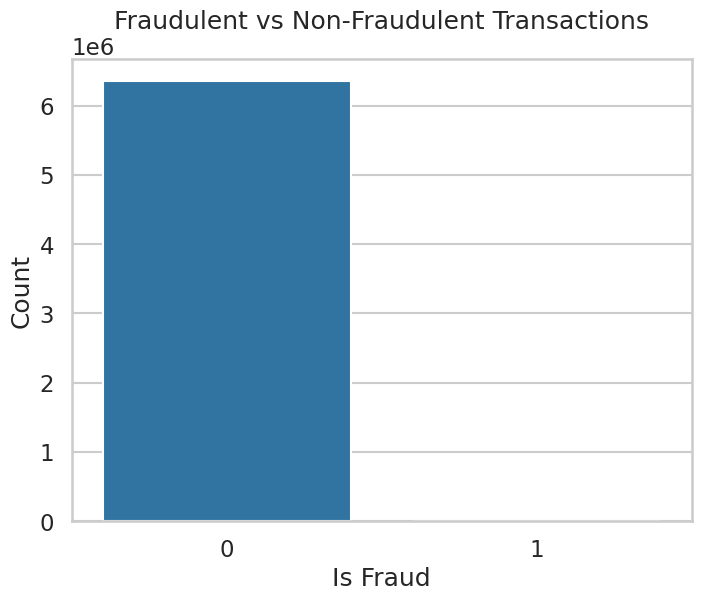

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [134]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'isFraud', data = df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()
print(df['isFraud'].value_counts())

By looking at the data above we can say that the dataset is highly imbalanced. Number of non-fraudulent transactions are much higher than fraudulent transactions.

### Time series of transaction frequency
time series is appearing to give some insights as most of transactions is between 15 to 20 hour of day

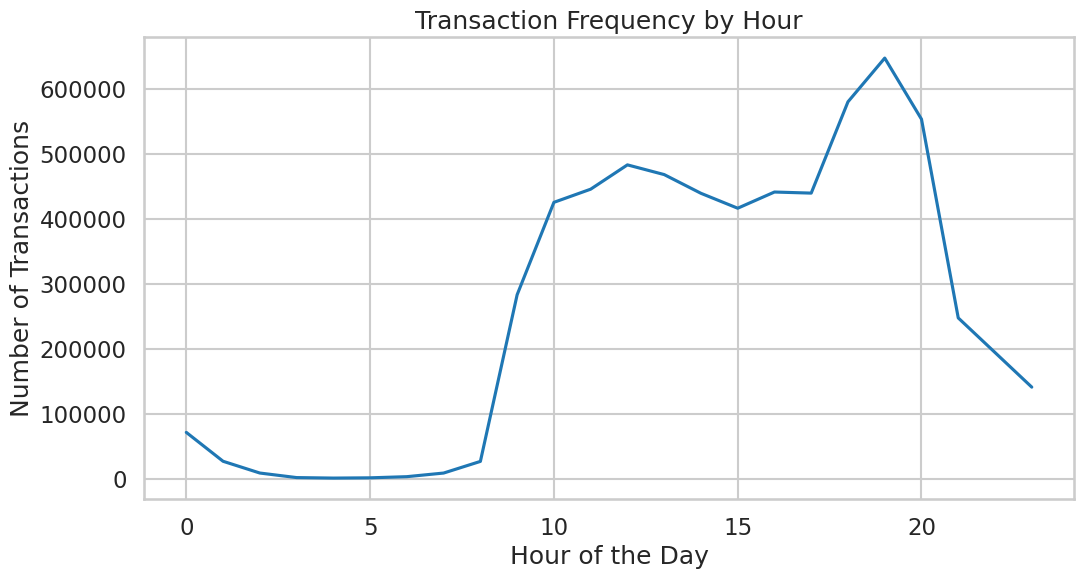

In [135]:
df['hour'] = df['step'] % 24
hourly_counts = df.groupby('hour').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Transaction Frequency by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.show()

###Fradulent transactions by transaction type

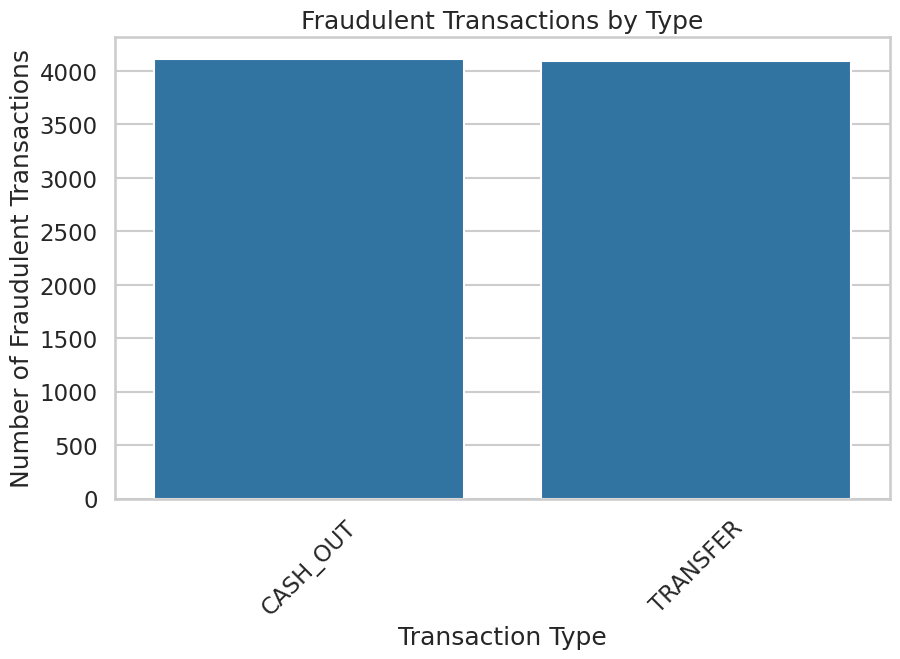

In [136]:
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title('Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

###Now let's perpare the data for training the model.

let's separate the feature by their data types, only the features that we'll use for training

then creates a preprocessor for the transformation of features

we'll use StandardScaler for numerical features to standardizes them to have mean 0 and variance 1.

and applying one-hot encoding to categorical features

In [137]:
categorical_features = ['type']
numerical_features = ['step', 'amount', 'newbalanceOrig',  'newbalanceDest']

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop = 'first'), categorical_features)
    ]
)


Now we'll drop the now-required features and split the data into training, validation and test sets.

In [138]:
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'oldbalanceOrg', 'oldbalanceDest'], axis = 1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(4072076, 6) (1018020, 6) (1272524, 6)
(4072076,) (1018020,) (1272524,)


let's fit the preprocessor on the training data and transform the numerical and categorical features

In [139]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


## Building the model
we have prepared our data for training now it's is turn to build the model.

we'll use a simple feedforward neural network with one hidden layer.Let's see how it performs

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class FraudDetectionModel(nn.Module):
  def __init__(self, input_dim):
    super(FraudDetectionModel, self).__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.sigmoid(self.layer3(x))
    return x

we have build a simple feedforward neural network with one hidden layer.Let's see how it performs
our model contains relu to introduce non-linearity and sigmoid to produce output between 0 and 1.

In [141]:
# checking the type to X_train
type(X_train)

numpy.ndarray

the type of X_train is numpy.ndarray so we need to convert it to torch.Tensor and we'll also transfer it to gpu for faster training

In [142]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1).to(device)


In [143]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

now initialize the model and define the loss function and optimizer

In [144]:
model = FraudDetectionModel(X_train_tensor.shape[1]).to(device)

initializing the loss and optimizer for training the model

In [145]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### time for the training loop

we have 5 steps for building the training loop in pytorch
1. model.train()
2. optimizer.zero_grad()
3. calculate the loss
4. loss.backward()
5. optimizer.step()

and then evaluation and print the results

In [146]:
num_epochs = 10
#storing the loss and accuracy  values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss/ len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)
    val_predictions = (val_outputs > 0.5).float()
    val_accuracy = (val_predictions == y_val_tensor).float().mean()

  val_losses.append(val_loss.item())
  val_accuracies.append(val_accuracy.item())

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}")



Epoch [1/10], Loss: 0.0002, Val Loss: 0.0036, Val Accuracy: 0.9993
Epoch [2/10], Loss: 0.0017, Val Loss: 0.0037, Val Accuracy: 0.9993
Epoch [3/10], Loss: 0.0000, Val Loss: 0.0036, Val Accuracy: 0.9993
Epoch [4/10], Loss: 0.0007, Val Loss: 0.0037, Val Accuracy: 0.9993
Epoch [5/10], Loss: 0.0002, Val Loss: 0.0034, Val Accuracy: 0.9994
Epoch [6/10], Loss: 0.0001, Val Loss: 0.0034, Val Accuracy: 0.9994
Epoch [7/10], Loss: 0.0002, Val Loss: 0.0035, Val Accuracy: 0.9994
Epoch [8/10], Loss: 0.0005, Val Loss: 0.0034, Val Accuracy: 0.9994
Epoch [9/10], Loss: 0.0000, Val Loss: 0.0035, Val Accuracy: 0.9994
Epoch [10/10], Loss: 0.0001, Val Loss: 0.0033, Val Accuracy: 0.9994


In [147]:
print(train_losses)
print(val_losses)
print(val_accuracies)

[0.005110505717767308, 0.0039006924329780344, 0.003760270236663862, 0.003889713585972196, 0.003922392832161474, 0.004012377931161299, 0.003708553133954639, 0.003899392435365712, 0.003994808546445302, 0.003949463317844746]
[0.0035935090854763985, 0.0036957887932658195, 0.0036325654946267605, 0.003668291727080941, 0.003386172465980053, 0.003358716145157814, 0.0035440768115222454, 0.0033553799148648977, 0.0034862030297517776, 0.0033405176363885403]
[0.9992976784706116, 0.9993005990982056, 0.9993428587913513, 0.9992868304252625, 0.9994391202926636, 0.9993634819984436, 0.9993664026260376, 0.9994056820869446, 0.9993595480918884, 0.9994086623191833]


plotting traning vs validation loss and accuracy

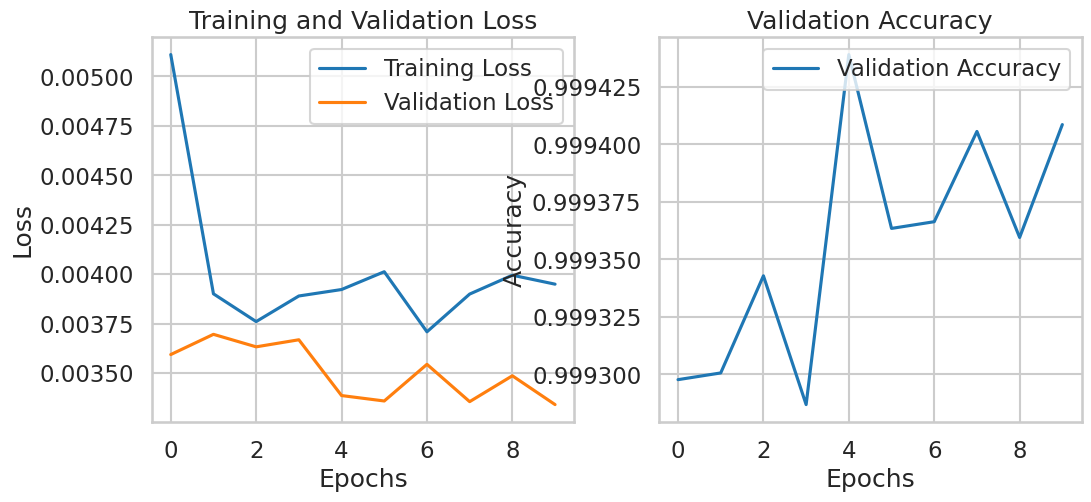

In [148]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

we have trained the model the loss is very low and accuracy is very high so we can assume the model is trained well but we'll test it on test data and compare it with that to reach the conclusion.

Let's test it on test set

In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
  test_outputs = model(X_test_tensor)
  test_predictions = (test_outputs > 0.5).float()

# Moving predictions back to cpu for sklearn metrics
test_predictions = test_predictions.cpu()
test_outputs = test_outputs.cpu()

accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_outputs)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9993681848043731
Precision: 0.8695652173913043
Recall: 0.5925925925925926
F1 Score: 0.7048458149779736
ROC AUC Score: 0.9739375065618696


the model is performing good on test set as well having accuracy above 99 % and precision above 97% which is good.


### Plotting Confusion Matrix and ROX curve

let's plot the confusion matrix and roc curve to get a better understanding of the model's performance

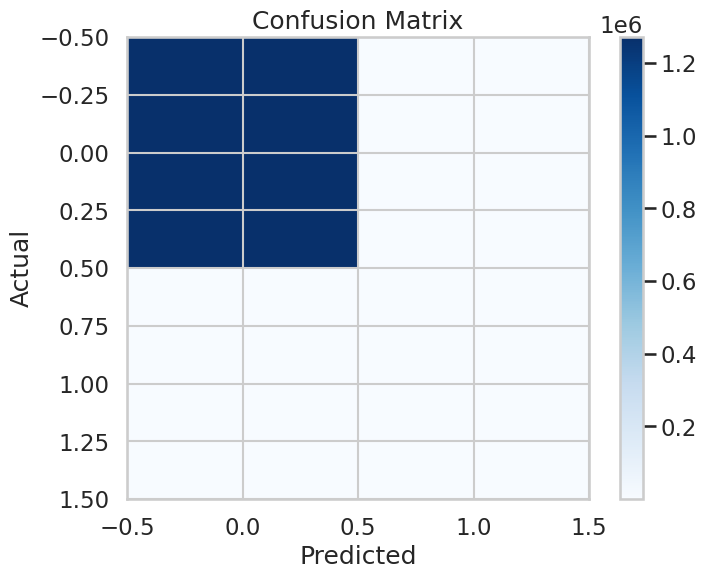

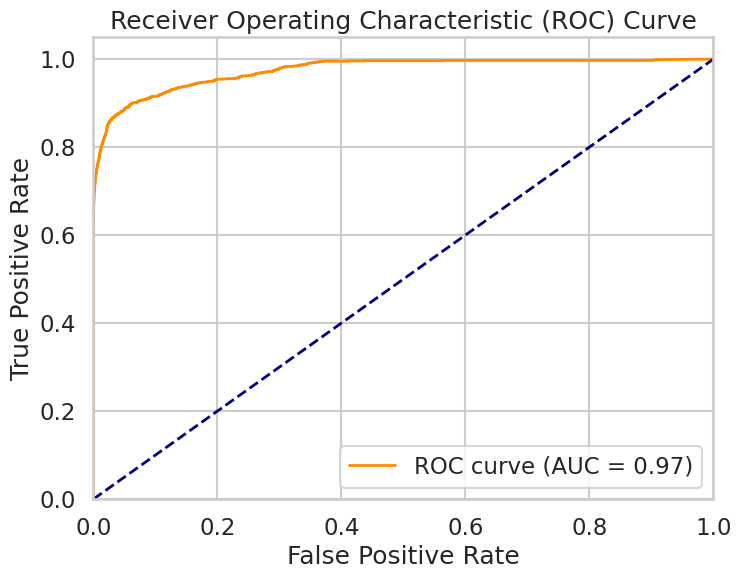

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize = (8, 6))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_outputs)
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

### Getting the feature importance which features contributed the most

In [152]:
# Feature Importance
feature_importance = model.layer1.weight.data.abs().mean(dim=0).cpu().numpy()
feature_names = numerical_features + [f"{cat}_{val}" for cat, val in zip(categorical_features, preprocessor.named_transformers_['cat'].categories_[0][1:])]


now let's get the length of feature_name and feature_importance to check if they are same

In [153]:
print(f"length of feature_names: { len(feature_names)}")
print(f"length of feature_importance: {len(feature_importance)}")

length of feature_names: 5
length of feature_importance: 8


the length of feature_names and feature_importance are not the same. we have to make them same first and then plot the feature importance

In [154]:
print("Feature names: ", feature_names)
print("Feature importance: ", feature_importance)

Feature names:  ['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'type_CASH_OUT']
Feature importance:  [0.28528756 0.4672095  0.95607704 0.7208056  0.8779388  0.23919517
 0.27203792 0.8362916 ]


getting numerica features and categorical_features and adding them to get the required no of feature_names

In [155]:
numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out()
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()

feature_names = list(numeric_features) + list(categorical_features)

print(f"number of features: {len(feature_names)}")
print("Feature names:")
print(feature_names)

number of features: 8
Feature names:
['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


let's create a dataframe with feature names and feature importance and sort it by feature importance

In [156]:
feature_importance = model.layer1.weight.data.abs().mean(dim = 0).cpu().numpy()
print(f"Number of importance values: {len(feature_importance)}")

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending = False)

print(importance_df.head(10))

Number of importance values: 8
          feature  importance
2  newbalanceOrig    0.956077
4   type_CASH_OUT    0.877939
7   type_TRANSFER    0.836292
3  newbalanceDest    0.720806
1          amount    0.467209
0            step    0.285288
6    type_PAYMENT    0.272038
5      type_DEBIT    0.239195


Plotting the top 10 features with their importance

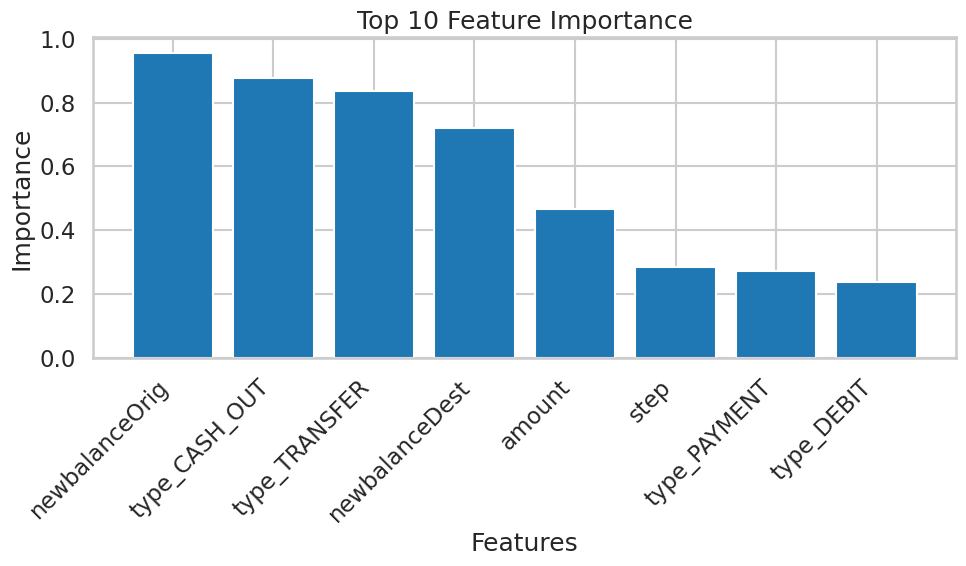

In [157]:
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'][:10], importance_df['importance'][:10])
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()